In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import datetime as dt

%matplotlib inline
f = open('recs.csv')
data = pd.read_csv(f,sep=',', header='infer', parse_dates=[1])

In [5]:
data.shape

(12083, 931)

In [6]:
X = data.iloc[:,0:839]
a = X['UR'].copy()
a[a == 'U'] = 1
a[a == 'R'] = 0
X['UR'] = a
X = X.drop('METROMICRO',axis=1).drop('DOEID',1)
X['NOCRCASH'] = X['NOCRCASH'].fillna(method = 'pad')
X['NKRGALNC'] = X['NKRGALNC'].fillna(method = 'pad')

In [37]:
y1 = data['TOTALBTUSPH']/data['TOTSQFT']
y2 = data['TOTALBTUCOL']/data['TOTSQFT']

In [195]:
goodies1 = y1 < 200
goodies2 = y2 < 25
temp = y1[y1<200]
X[goodies1]
X[goodies2]

12067

In [38]:
from sklearn.ensemble import ExtraTreesRegressor
model1 = ExtraTreesRegressor().fit(X,y1)
model2 = ExtraTreesRegressor().fit(X,y2)

In [39]:
a1  = model1.feature_importances_
a2  = model2.feature_importances_

In [63]:
d = {'fname':X.columns.values, 'score1':a1,'score2':a2}
fsl = pd.DataFrame(d)
fsl.sort_values(ascending=False, by='score1',inplace=True)
fsl.to_csv('feature_importance.csv')

In [174]:
fsl.sort_values(ascending=False, by='score1').head(10)

,fname,score1,score2
826,TOTSQFT_EN,0.077509,0.003977
825,TOTSQFT,0.073985,0.003615
29,NCOMBATH,0.066790,0.001045
10,AIA_Zone,0.066381,0.174042
434,HEATOTH,0.061899,0.000191
428,FUELHEAT,0.047722,0.000288
665,UGWARM,0.042870,0.000288
2,REPORTABLE_DOMAIN,0.040212,0.000535
675,FOWARM,0.028245,0.000007
703,PGASHEAT,0.023065,0.000357


In [198]:
# Remember to change both bests and newY!
bests = fsl.sort_values(ascending=False, by='score1')['fname'].values[0:10]
print(bests)
newX2 = X[bests]
newY = y1
#newX2 = data[['AIA_Zone','CDD30YR','USEWWAC','TEMPGONEAC','HDD30YR','TEMPNITEAC','ELCOOL','USECENAC','TOTUCSQFT','COOLTYPE']]

['TOTSQFT_EN' 'TOTSQFT' 'NCOMBATH' 'AIA_Zone' 'HEATOTH' 'FUELHEAT' 'UGWARM'
 'REPORTABLE_DOMAIN' 'FOWARM' 'PGASHEAT']


In [199]:
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.cross_validation import cross_val_score
s5 = [0]*len(levels1)
for i in levels1:
    treeA2 = DTR(max_depth = i).fit(newX2,newY)
    score = cross_val_score(treeA2, newX2, newY, cv=10)
    s5[i-1] = np.mean(score)
    print(i,'the cross validation result of treeA2 is: \n',np.mean(score))

1 the cross validation result of treeA2 is: 
 0.155144331021
2 the cross validation result of treeA2 is: 
 0.23010230136
3 the cross validation result of treeA2 is: 
 0.397486958287
4 the cross validation result of treeA2 is: 
 0.506989419137
5 the cross validation result of treeA2 is: 
 0.583143301496
6 the cross validation result of treeA2 is: 
 0.603786005092
7 the cross validation result of treeA2 is: 
 0.64500491222
8 the cross validation result of treeA2 is: 
 0.653979718535
9 the cross validation result of treeA2 is: 
 0.570754000637
10 the cross validation result of treeA2 is: 
 0.578024572723
11 the cross validation result of treeA2 is: 
 0.542139296878


<function matplotlib.pyplot.show>

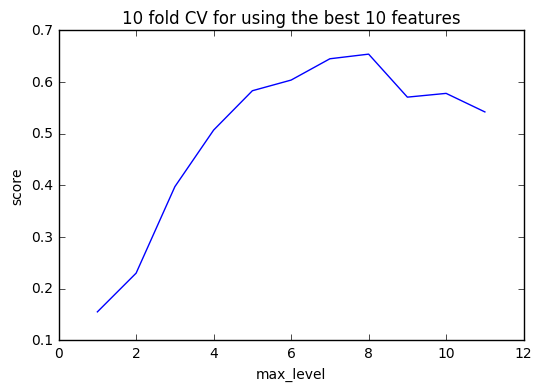

In [200]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.plot(levels1,s5)
ax1.set_xlabel('max_level')
ax1.set_ylabel('score')
# plt.ylim(0,0.7)
plt.title('10 fold CV for using the best 10 features')
plt.show

In [178]:
levels2 = range(1,20,2)
s2 = [0]*len(levels2)
for i in range(0,len(levels2)):
    d = levels2[i]
    treeMeta = DTR(max_depth=d).fit(X, newY)
    score2 = cross_val_score(treeMeta, X, newY, cv=10)
    s2[i] = np.mean(score2)
    print(i, 'the cross validation result of treeMeta is: \n',np.mean(score2))

0 the cross validation result of treeMeta is: 
 0.155144331021
1 the cross validation result of treeMeta is: 
 0.413694801118
2 the cross validation result of treeMeta is: 
 0.56550125918
3 the cross validation result of treeMeta is: 
 0.61588819881
4 the cross validation result of treeMeta is: 
 0.567099978158
5 the cross validation result of treeMeta is: 
 0.52619025612
6 the cross validation result of treeMeta is: 
 0.518283508708
7 the cross validation result of treeMeta is: 
 0.46071223497
8 the cross validation result of treeMeta is: 
 0.433106475561
9 the cross validation result of treeMeta is: 
 0.461928663788


<function matplotlib.pyplot.show>

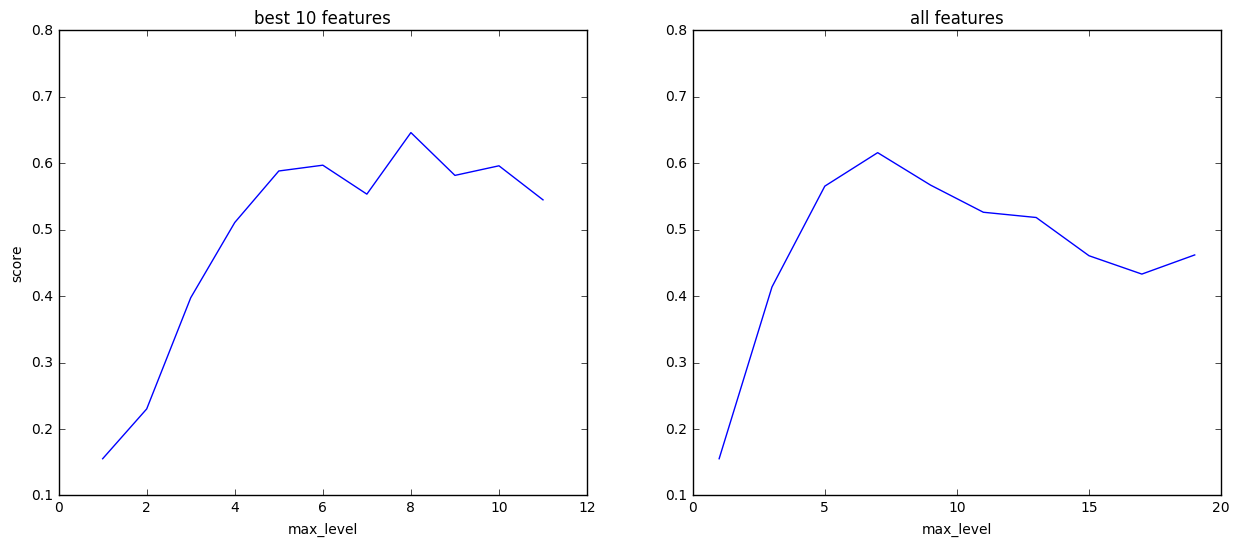

In [179]:
fig2 = plt.figure(figsize = (15,6))
ax1 = fig2.add_subplot(121)
plt.plot(levels1,s5)
ax1.set_xlabel('max_level')
ax1.set_ylabel('score')
# plt.ylim(0,0.7)
plt.title('best 10 features')
plt.ylim(0.1,0.8)
plt.show

ax2 = fig2.add_subplot(122)
plt.plot(levels2,s2)
ax2.set_xlabel('max_level')
plt.title('all features')
plt.ylim(0.1,0.8)
plt.show

In [95]:
randX = X.iloc[:,np.random.permutation(X.shape[1])]
randX = randX.iloc[:,0:10]
s3 = [0]*len(levels1)
for i in levels1:
    treeRand = DTR(max_depth = i).fit(randX,newY)
    score = cross_val_score(treeRand, randX, newY, cv=10)
    s3[i-1] = np.mean(score)
    print(i,'the cross validation result of treeA is: \n',np.mean(score))

1 the cross validation result of treeA is: 
 0.0388470624614
2 the cross validation result of treeA is: 
 0.041642645619
3 the cross validation result of treeA is: 
 0.0394287510232
4 the cross validation result of treeA is: 
 0.0385447454782
5 the cross validation result of treeA is: 
 0.0406639022861
6 the cross validation result of treeA is: 
 0.0367679102506
7 the cross validation result of treeA is: 
 0.0351857024008
8 the cross validation result of treeA is: 
 0.0319676884375
9 the cross validation result of treeA is: 
 0.0287835944772
10 the cross validation result of treeA is: 
 0.0272754787293
11 the cross validation result of treeA is: 
 0.0229673379744


In [181]:
humanX = X[['REPORTABLE_DOMAIN','HDD30YR','TYPEHUQ','Climate_Region_Pub','AIA_Zone','YEARMADE','WALLTYPE','ROOFTYPE','TOTSQFT','HEATOTH']]
#humanX = X[['REPORTABLE_DOMAIN','CDD30YR','HDD30YR','AIA_Zone','YEARMADE','WALLTYPE','ROOFTYPE','TOTSQFT','KOWNRENT','UR']]
s4 = [0]*len(levels1)
for i in levels1:
    treeRand = DTR(max_depth = i).fit(humanX,newY)
    score = cross_val_score(treeRand, humanX, newY, cv=10)
    s4[i-1] = np.mean(score)
    print(i,'the cross validation result of treeA is: \n',np.mean(score))


1 the cross validation result of treeA is: 
 0.159062233216
2 the cross validation result of treeA is: 
 0.203960519749
3 the cross validation result of treeA is: 
 0.273640875548
4 the cross validation result of treeA is: 
 0.329404713914
5 the cross validation result of treeA is: 
 0.337039429522
6 the cross validation result of treeA is: 
 0.359562891946
7 the cross validation result of treeA is: 
 0.337218128363
8 the cross validation result of treeA is: 
 0.355463284741
9 the cross validation result of treeA is: 
 0.355483322583
10 the cross validation result of treeA is: 
 0.32194326942
11 the cross validation result of treeA is: 
 0.285356611533


<function matplotlib.pyplot.show>

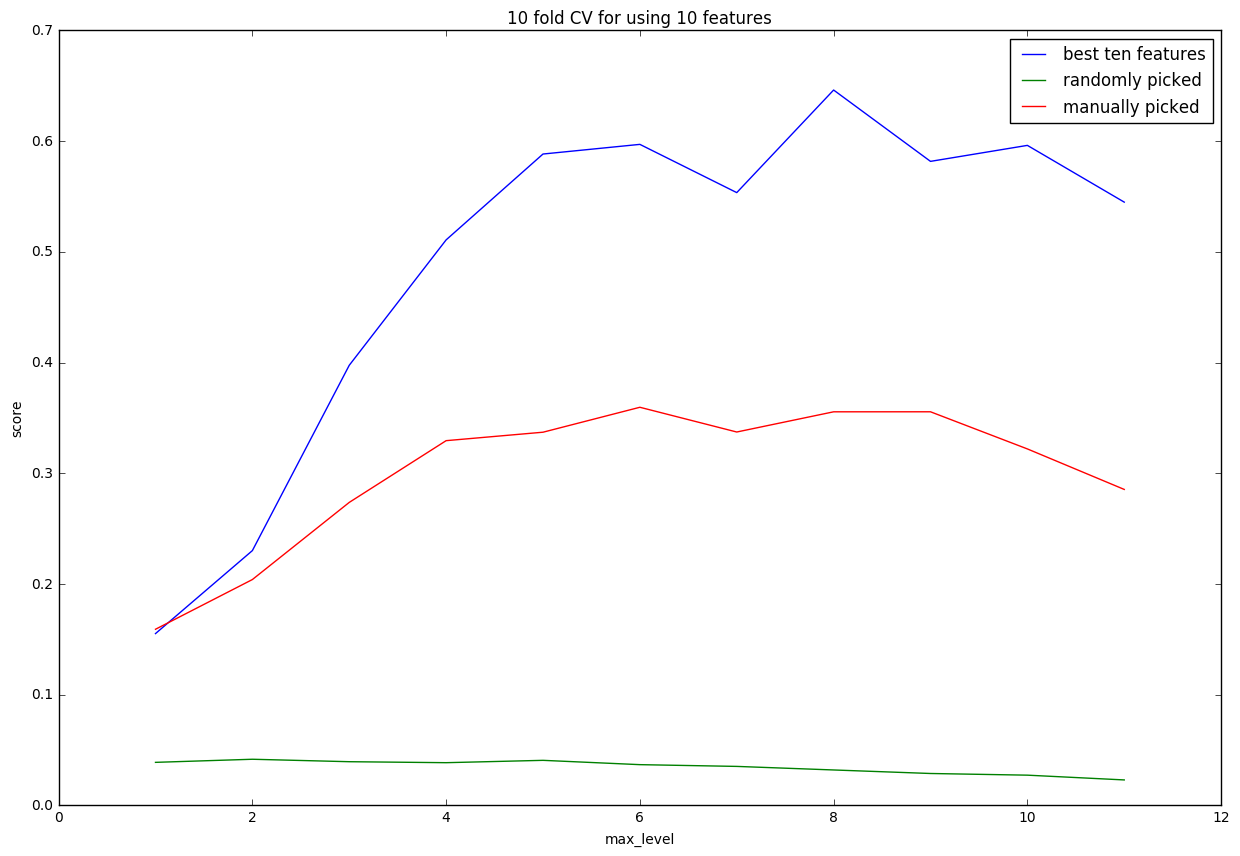

In [182]:
fig1 = plt.figure(figsize = (15,10))
ax1 = fig1.add_subplot(111)
plt.plot(levels1,s5,label = 'best ten features')
# plt.plot(levels1,s2)
plt.plot(levels1,s3,label = 'randomly picked')
plt.plot(levels1,s4,label = 'manually picked')
plt.legend()
ax1.set_xlabel('max_level')
ax1.set_ylabel('score')
# plt.ylim(0,0.7)

plt.title('10 fold CV for using 10 features')
plt.show

In [183]:
treeA = DTR(max_depth = 9).fit(newX2,newY)
predict = treeA.predict(newX2)
d = {'actual':newY, 'predict':predict}
vs = pd.DataFrame(d)
vs.head()

,actual,predict
0,2.142463,4.411219
1,12.310587,9.227653
2,76.227273,106.398179
3,19.869501,35.351672
4,18.899582,35.351672


In [184]:
idx = np.asarray(list(vs.index))
np.log(idx+1)*25

array([   0.        ,   17.32867951,   27.46530722, ...,  234.98473124,
        234.98680052,  234.98886963])

<function matplotlib.pyplot.show>

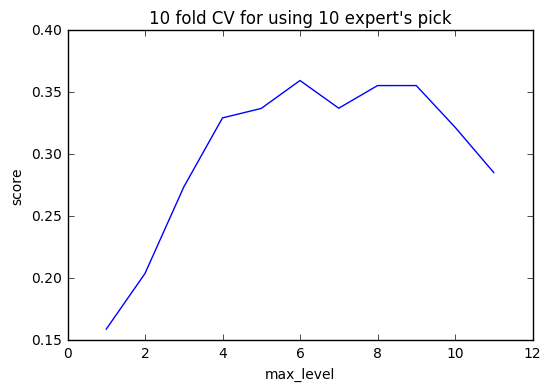

In [185]:
fig4 = plt.figure()
ax3 = fig4.add_subplot(111)
plt.plot(levels1,s4)
ax3.set_xlabel('max_level')
ax3.set_ylabel('score')
plt.title('10 fold CV for using 10 expert\'s pick')
plt.show

C:\Users\cleme\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


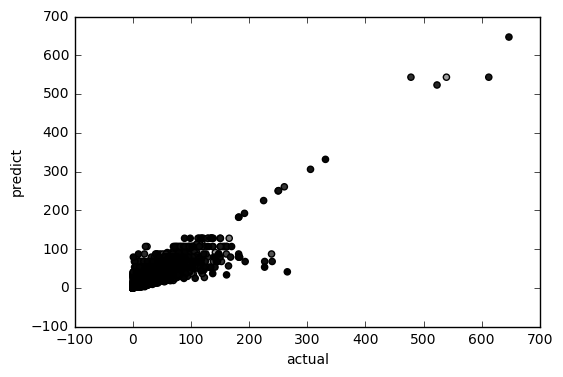

In [186]:
import math
fig1 = plt.figure(figsize = (12,8))
#plt.plot((newY-predict),'r',alpha = 0.3,label = 'predicted')
vs.plot(kind='scatter', x='actual', y='predict', c=np.log(idx+1)*25);
#plt.xlim(0,12100)
plt.legend()
plt.show()